# Notebook of comparison VAE and geometric VAE

In [1]:
import numpy as np
import pandas as pd
import scanpy as sc

from scCFM.models.base.vae import VAE
from scCFM.models.base.geometric_vae import GeometricNBVAE, GeometricNBAE
from scCFM.models.base.geodesic_ae import GeodesicAE
from scCFM.datamodules.sc_datamodule import scDataModule

from scCFM.models.manifold.geometry_metrics import compute_all_metrics

import sys
sys.path.insert(0, "../..")
from notebooks.utils import real_reconstructed_cells_adata

from paths import PROJECT_FOLDER
import torch
import anndata

import scipy

import seaborn as sns

/nfs/staff-ssd/pala/miniconda3/envs/scCFM/lib/python3.10/site-packages/scvi/_settings.py:63: UserWarning: Since v1.0.0, scvi-tools no longer uses a random seed by default. Run `scvi.settings.seed = 0` to reproduce results from previous versions.
  self.seed = seed
/nfs/staff-ssd/pala/miniconda3/envs/scCFM/lib/python3.10/site-packages/scvi/_settings.py:70: UserWarning: Setting `dl_pin_memory_gpu_training` is deprecated in v1.0 and will be removed in v1.1. Please pass in `pin_memory` to the data loaders instead.
  self.dl_pin_memory_gpu_training = (
No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


In [2]:
terminal_states = [6]
initial_states = [0]

**Util functions**

## Initialize the two different configurations 

General module hparams

In [3]:
datamodule={'path': PROJECT_FOLDER / 'data/hein_et_al/processed/unperturbed_time_course_host.h5ad', 
            'x_layer': 'X_norm', 
            'cond_keys': ['experimental_time', 'cluster'],
            'use_pca': False, 
            'n_dimensions': None, 
            'train_val_test_split': [0.5, 0.5], 
            'batch_size': 128, 
            'num_workers': 2}


# Initialize datamodule
datamodule = scDataModule(**datamodule)

### Model config VAE

In [4]:
model_vae={
       'in_dim': datamodule.in_dim,
       'n_epochs_anneal_kl': 1000, 
       'kl_weight': None, 
       'likelihood': 'nb', 
       'dropout': False, 
       'learning_rate': 0.001, 
       'dropout_p': False, 
       'model_library_size': True, 
       'batch_norm': True, 
       'kl_warmup_fraction': 0.1, 
       'hidden_dims': [256, 10]}
        
geometric={'compute_metrics_every': 1, 
           'use_c': True, 
           'l2': True, 
           'eta_interp': 0, 
           'interpolate_z': False, 
           'start_jac_after': 0, 
           'fl_weight': 0.1,
           'detach_theta': True}

geodesic={"in_dim": datamodule.in_dim,
          "hidden_dims": [256, 10],
          "batch_norm": True,
          "dropout": False, 
          "dropout_p": False,
          "likelihood": "nb",
          "learning_rate": 0.001}

In [5]:
vae = GeometricNBVAE(**geometric, vae_kwargs=model_vae).eval()
geometric_vae = GeometricNBVAE(**geometric, vae_kwargs=model_vae).eval()
geodesic_ae = GeodesicAE(**geodesic).eval()

In [6]:
# vae = GeometricNBAE(**geometric, vae_kwargs=model_ae)
# geometric_vae = GeometricNBAE(**geometric, vae_kwargs=model_ae)

In [7]:
# vae.load_state_dict(torch.load(PROJECT_FOLDER / "checkpoints/ae/hein_et_al/best_model_vae_lib.ckpt")["state_dict"])
# geometric_vae.load_state_dict(torch.load(PROJECT_FOLDER / "checkpoints/ae/hein_et_al/best_model_geometric_lib.ckpt")["state_dict"])

In [8]:
vae.load_state_dict(torch.load(PROJECT_FOLDER / "checkpoints/ae/hein_et_al_complete/best_model_vae_lib.ckpt")["state_dict"])
geometric_vae.load_state_dict(torch.load(PROJECT_FOLDER / "checkpoints/ae/hein_et_al_complete/best_model_geometric_lib.ckpt")["state_dict"])
geodesic_ae.load_state_dict(torch.load(PROJECT_FOLDER / "checkpoints/ae/hein_et_al_complete/best_model_geodesic_ae.ckpt")["state_dict"])

<All keys matched successfully>

In [9]:
from pytorch_lightning import Trainer

trainer_vae = Trainer(inference_mode=False)
trainer_geometric = Trainer(inference_mode=False)

/nfs/staff-ssd/pala/miniconda3/envs/scCFM/lib/python3.10/site-packages/lightning_fabric/plugins/environments/slurm.py:168: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /nfs/staff-ssd/pala/miniconda3/envs/scCFM/lib/python ...
  rank_zero_warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/nfs/staff-ssd/pala/miniconda3/envs/scCFM/lib/python3.10/site-packages/lightning_fabric/plugins/environments/slurm.py:168: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /nfs/staff-ssd/pala/miniconda3/envs/scCFM/lib/python ...
  rank_zero_warn(
GPU available: True (cuda), used: True
TPU available

In [10]:
trainer_vae.validate(model=vae, dataloaders=datamodule.train_dataloader())

/nfs/staff-ssd/pala/miniconda3/envs/scCFM/lib/python3.10/site-packages/lightning_fabric/plugins/environments/slurm.py:168: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /nfs/staff-ssd/pala/miniconda3/envs/scCFM/lib/python ...
  rank_zero_warn(
You are using a CUDA device ('NVIDIA A100-PCIE-40GB') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/nfs/staff-ssd/pala/miniconda3/envs/scCFM/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:490: PossibleUserWarning: Your `val_dataloader`'s sampler has shuffling 

Validation: 0it [00:00, ?it/s]

/nfs/staff-ssd/pala/miniconda3/envs/scCFM/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/logger_connector/result.py:212: UserWarning: You called `self.log('reg_weight', ...)` in your `validation_step` but the value needs to be floating point. Converting it to torch.float32.
  warning_cache.warn(


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│     condition_number      │     109.1248550415039     │
│        eu_kl_corr         │     0.714342474937439     │
│        eu_kl_dist         │     320.5332336425781     │
│         fl_weight         │    0.09999994933605194    │
│   magnification_factor    │            inf            │
│        reg_weight         │            0.0            │
│        val/fl_loss        │      519094272000.0       │
│          val/kl           │     19.63489532470703     │
│          val/lik          │     899.079345703125      │
│         val/loss          │       51909435392.0       │
│         val/norm          │     41.68886184692383     │
│         variance          │     28.4674129486084      │
└───────────────────────────┴───────────────────────────┘

[{'val/loss': 51909435392.0,
  'val/kl': 19.63489532470703,
  'val/lik': 899.079345703125,
  'val/fl_loss': 519094272000.0,
  'val/norm': 41.68886184692383,
  'reg_weight': 0.0,
  'fl_weight': 0.09999994933605194,
  'condition_number': 109.1248550415039,
  'variance': 28.4674129486084,
  'magnification_factor': inf,
  'eu_kl_dist': 320.5332336425781,
  'eu_kl_corr': 0.714342474937439}]

In [11]:
trainer_vae.validate(model=geometric_vae, dataloaders=datamodule.train_dataloader())

/nfs/staff-ssd/pala/miniconda3/envs/scCFM/lib/python3.10/site-packages/lightning_fabric/plugins/environments/slurm.py:168: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /nfs/staff-ssd/pala/miniconda3/envs/scCFM/lib/python ...
  rank_zero_warn(
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/nfs/staff-ssd/pala/miniconda3/envs/scCFM/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:490: PossibleUserWarning: Your `val_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test dataloaders.
  rank_zero_warn(
/nfs/staff-ssd/pala/miniconda3/envs/scCFM/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:442: PossibleUserWarning: The dataloader, val_dataloader, does not have many workers which may be a bottleneck. Consider increas

Validation: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│     condition_number      │     332.5077819824219     │
│        eu_kl_corr         │    0.7389821410179138     │
│        eu_kl_dist         │     279.7308349609375     │
│         fl_weight         │    0.09999994933605194    │
│   magnification_factor    │    56.346771240234375     │
│        reg_weight         │            0.0            │
│        val/fl_loss        │        79391.96875        │
│          val/kl           │    108.52619171142578     │
│          val/lik          │     1072.874267578125     │
│         val/loss          │       9012.0703125        │
│         val/norm          │    163.50778198242188     │
│         variance          │     6.503434658050537     │
└───────────────────────────┴───────────────────────────┘

[{'val/loss': 9012.0703125,
  'val/kl': 108.52619171142578,
  'val/lik': 1072.874267578125,
  'val/fl_loss': 79391.96875,
  'val/norm': 163.50778198242188,
  'reg_weight': 0.0,
  'fl_weight': 0.09999994933605194,
  'condition_number': 332.5077819824219,
  'variance': 6.503434658050537,
  'magnification_factor': 56.346771240234375,
  'eu_kl_dist': 279.7308349609375,
  'eu_kl_corr': 0.7389821410179138}]

**Save anndata**

In [12]:
PROJECT_FOLDER / "data/hein_et_al/flat/"

PosixPath('/nfs/homedirs/pala/scCFM/project_dir/data/hein_et_al/flat')

In [13]:
# adata_vae_z.layers["X_latents"] = adata_vae_z.X.copy()
# adata_vae_z.write_h5ad(PROJECT_FOLDER / "data/hein_et_al/flat/hein_lib_complete.h5ad")

In [14]:
# adata_geometric_z.layers["X_latents"] = adata_geometric_z.X.copy()
# adata_geometric_z.write_h5ad(PROJECT_FOLDER / "data/hein_et_al/flat/hein_flat_lib_complete.h5ad")

In [28]:
# adata_geodesic_z.layers["X_latents"] = adata_geodesic_z.X.copy()
# adata_geodesic_z.write_h5ad(PROJECT_FOLDER / "data/hein_et_al/flat/hein_geodesic_lib.h5ad")

**Compare latents**

In [57]:
annot = ["geometric" for _ in range(len(adata_geometric_z))] + ["normal" for _ in range(len(adata_vae_z))]
concat = anndata.concat([adata_geometric_z, adata_vae_z], merge="same")
concat.obs["dataset_type"] = annot

/nfs/staff-ssd/pala/miniconda3/envs/cellrank_scvelo/lib/python3.8/site-packages/anndata/_core/anndata.py:1838: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


/nfs/staff-ssd/pala/miniconda3/envs/cellrank_scvelo/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


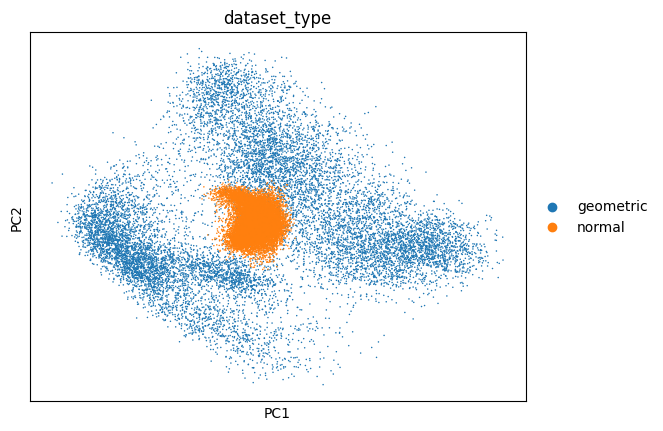

In [58]:
sc.tl.pca(concat)
sc.pl.pca(concat, color="dataset_type")

/nfs/staff-ssd/pala/miniconda3/envs/cellrank_scvelo/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


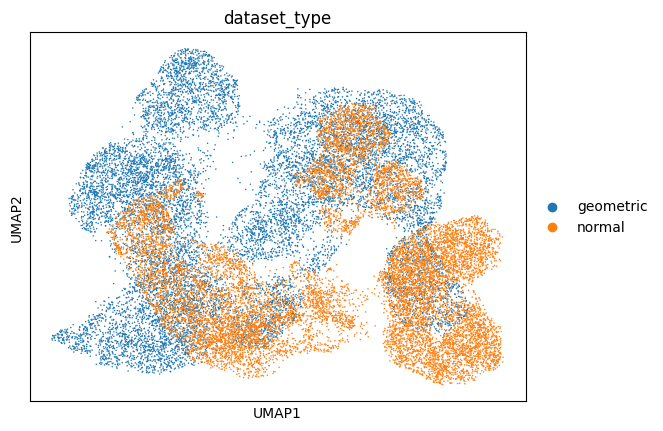

In [59]:
sc.pl.umap(concat, color="dataset_type")

**Latent sizes**

<Axes: xlabel='values', ylabel='Count'>

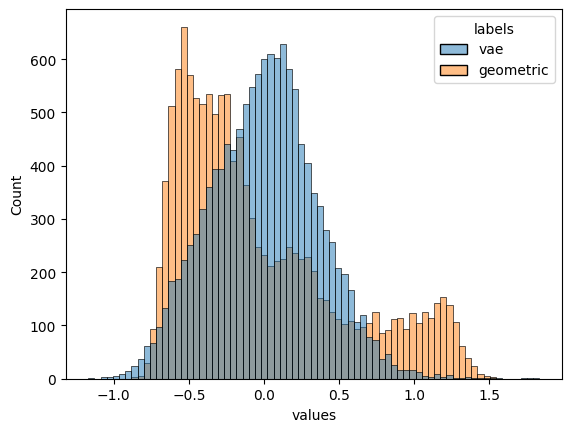

In [60]:
vae_mean_df = make_joint_df([adata_vae_z.X.mean(1), adata_geometric_z.X.mean(1)], 
                              ["vae", "geometric"])
sns.histplot(vae_mean_df, x="values", hue="labels")

**Compare real and generated data**

In [61]:
adata_real = adata_vae_amortized_real[adata_vae_amortized_real.obs['dataset_type']=="real"]
adata_generated_vae = adata_vae_amortized_real[adata_vae_amortized_real.obs['dataset_type']=="generated_amortized"]
adata_generated_geometric = adata_geometric_amortized_real[adata_geometric_amortized_real.obs['dataset_type']=="generated_amortized"]

adata_real.layers["X_norm"] = np.exp(adata_real.X)-1
adata_generated_vae.layers["X_norm"] = np.exp(adata_generated_vae.X)-1
adata_generated_geometric.layers["X_norm"] = np.exp(adata_generated_geometric.X)-1

In [62]:
adata_generated_vae.X

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 3., 2., 0.],
       ...,
       [0., 0., 0., ..., 8., 4., 0.],
       [0., 0., 0., ..., 4., 4., 0.],
       [0., 0., 0., ..., 0., 1., 0.]], dtype=float32)

<Axes: xlabel='values', ylabel='Count'>

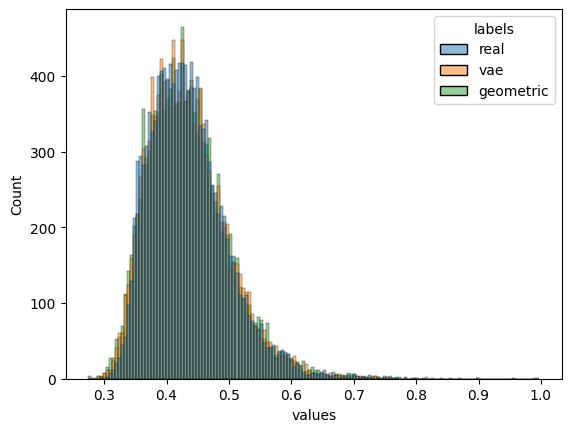

In [63]:
vae_mean_df = make_joint_df([adata_real.X.mean(1), 
                             adata_generated_vae.X.mean(1), 
                             adata_generated_geometric.X.mean(1)], 
                              ["real", "vae", "geometric"])
sns.histplot(vae_mean_df, x="values", hue="labels")

<Axes: xlabel='values', ylabel='Count'>

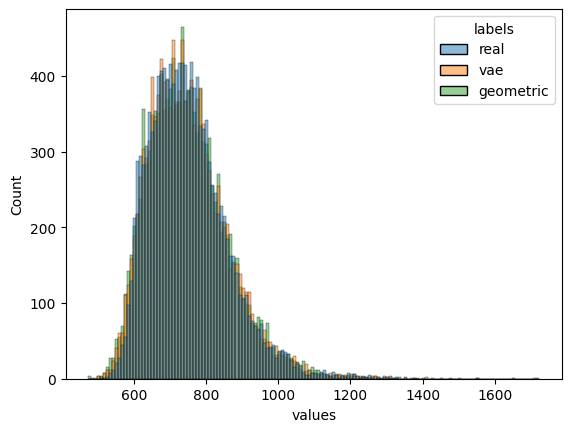

In [64]:
vae_mean_df = make_joint_df([adata_real.X.sum(1), 
                             adata_generated_vae.X.sum(1), 
                             adata_generated_geometric.X.sum(1)], 
                              ["real", "vae", "geometric"])
sns.histplot(vae_mean_df, x="values", hue="labels")

<Axes: xlabel='values', ylabel='Count'>

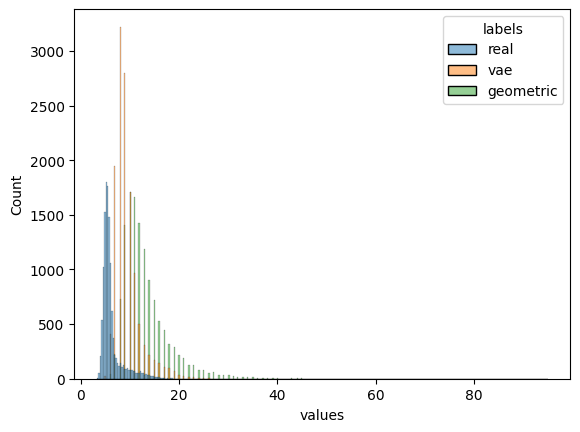

In [65]:
vae_mean_df = make_joint_df([adata_real.X.max(1), 
                             adata_generated_vae.X.max(1), 
                             adata_generated_geometric.X.max(1)], 
                              ["real", "vae", "geometric"])
sns.histplot(vae_mean_df, x="values", hue="labels")

<Axes: xlabel='values', ylabel='Count'>

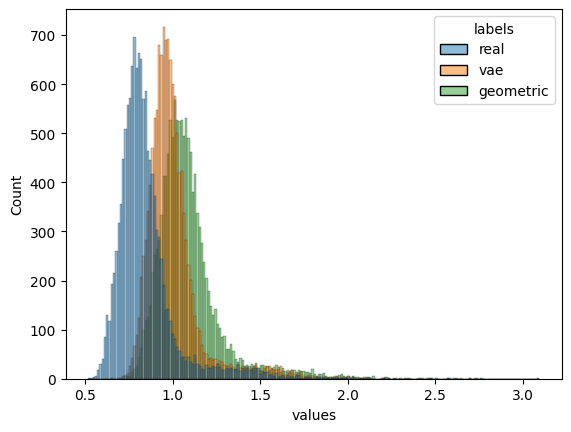

In [66]:
vae_mean_df = make_joint_df([adata_real.X.std(1), 
                             adata_generated_vae.X.std(1), 
                             adata_generated_geometric.X.std(1)], 
                              ["real", "vae", "geometric"])
sns.histplot(vae_mean_df, x="values", hue="labels")

<Axes: xlabel='values', ylabel='Count'>

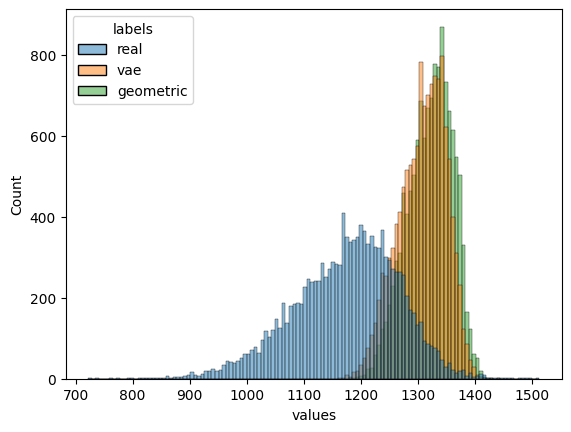

In [67]:
vae_mean_df = make_joint_df([(adata_real.X==0).sum(1), 
                             (adata_generated_vae.X==0).sum(1), 
                             (adata_generated_geometric.X==0).sum(1)], 
                              ["real", "vae", "geometric"])
sns.histplot(vae_mean_df, x="values", hue="labels")

<Axes: xlabel='values', ylabel='Count'>

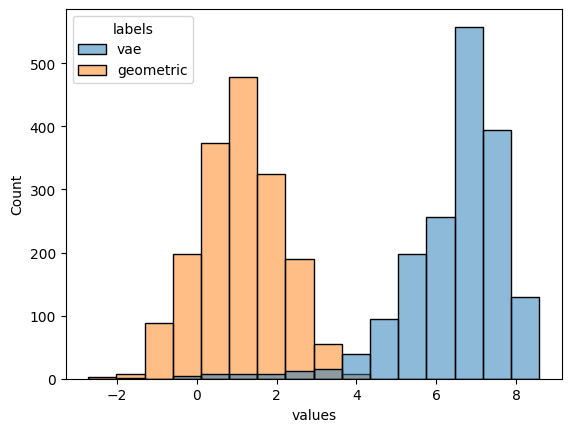

In [68]:
vae_mean_df = make_joint_df([vae.theta.detach().cpu().numpy(), 
                             geometric_vae.theta.detach().cpu().numpy()], 
                              ["vae", "geometric"])
sns.histplot(vae_mean_df, x="values", hue="labels")

In [69]:
torch.exp(geometric_vae.theta)

tensor([0.4818, 2.1762, 7.2397,  ..., 8.0512, 7.9185, 7.3576], device='cuda:0',
       grad_fn=<ExpBackward0>)

In [70]:
torch.exp(vae.theta)

tensor([ 109.8402,  734.5538,  363.7724,  ..., 2933.0808, 3004.5212,
        1346.9189], device='cuda:0', grad_fn=<ExpBackward0>)

In [71]:
adata = sc.read_h5ad("/nfs/homedirs/pala/scCFM/project_dir/data/hein_et_al/processed/unperturbed_time_course_host.h5ad")

In [72]:
adata.layers["X_norm"].A.max()

24.73482

In [73]:
adata.var

,ENSMBL,gene ID,mt,is_host,highly_variable,means,dispersions,dispersions_norm
gene ID,,,,,,,,
RP11-54O7.3,ENSG00000223764,RP11-54O7.3,False,True,True,0.020879,-0.245798,0.659897
SAMD11,ENSG00000187634,SAMD11,False,True,True,0.147365,-0.246578,1.700293
PLEKHN1,ENSG00000187583,PLEKHN1,False,True,True,0.031576,-0.273150,0.542630
HES4,ENSG00000188290,HES4,False,True,True,0.838479,-0.819448,0.765280
ISG15,ENSG00000187608,ISG15,False,True,True,1.624209,-0.516369,2.157820
...,...,...,...,...,...,...,...,...
ORFS369W,ORFS369W,ORFS369W,False,False,True,0.885551,0.476379,3.091739
ORFS371W_(US34),ORFS371W_(US34),ORFS371W_(US34),False,False,True,0.462203,0.195950,3.810770
ORFS372W,ORFS372W,ORFS372W,False,False,True,0.811727,0.506042,4.248973
